In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt

In [2]:
data_dir = 'data/mimic-iv-1.0/physionet.org/files/mimiciv/1.0/'
core = data_dir+'core/' 
hosp = data_dir+'hosp/'
icu = data_dir+'icu/'

In [3]:
patients = pd.read_csv(core+'patients.csv')
admissions = pd.read_csv(core+'admissions.csv')
transfers = pd.read_csv(core+'transfers.csv')
icd = pd.read_csv(hosp+'d_icd_diagnoses.csv')
diagnoses_icd = pd.read_csv(hosp+'diagnoses_icd.csv')

In [4]:
labs_dtype = {
    "labevent_id": "Int64",
    "subject_id": "Int64",
    "hadm_id": "Int64",
    "specimen_id": "Int64",
    "itemid": "Int64",
    "order_provider_id": "string",
    "value": "string",
    "valuenum": "float64",
    "valueuom": "string",
    "ref_range_lower": "float64",
    "ref_range_upper": "float64",
    "flag": "string",
    "priority": "string",
    "comments": "string"
}

In [6]:
labs = dd.read_csv(hosp+'labevents.csv', dtype=labs_dtype, parse_dates=["charttime", "storetime"])

In [7]:
labs.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,670,10000048,<NA>,6448755,51484,2126-11-22 19:20:00,2126-11-22 20:07:00,150,150.000,mg/dL,NaN,NaN,<NA>,STAT,<NA>
1,673,10000048,<NA>,6448755,51491,2126-11-22 19:20:00,2126-11-22 20:07:00,6.5,6.500,units,5.000,8.000,<NA>,STAT,<NA>
2,675,10000048,<NA>,6448755,51498,2126-11-22 19:20:00,2126-11-22 20:07:00,1.029,1.029,,1.001,1.035,<NA>,STAT,<NA>
3,683,10000048,<NA>,82729055,50861,2126-11-22 20:45:00,2126-11-23 00:55:00,39,39.000,IU/L,0.000,40.000,<NA>,STAT,<NA>
4,684,10000048,<NA>,82729055,50862,2126-11-22 20:45:00,2126-11-23 00:55:00,4.7,4.700,g/dL,3.400,4.800,<NA>,STAT,<NA>


In [8]:
neonatal_patients = patients[patients['anchor_age'] == 0]
len(neonatal_patients)

60872

In [9]:
diagnoses = diagnoses_icd.merge(icd, on=['icd_code', 'icd_version'], how='inner')
diagnoses.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
0,15734973,20475282,3,2825,9,Sickle-cell trait
1,15734973,20475282,2,V0251,9,Carrier or suspected carrier of group B strept...
2,15734973,20475282,5,V270,9,"Outcome of delivery, single liveborn"
3,15734973,20475282,1,64891,9,Other current conditions classifiable elsewher...
4,15734973,20475282,4,66481,9,"Other specified trauma to perineum and vulva, ..."


In [10]:
diagnoses[diagnoses['icd_code'] == 76529]

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title


In [55]:
premature_diagnoses = diagnoses[((diagnoses['icd_code'].str.startswith('P07')) & (diagnoses['icd_version'] == 10)) | ((diagnoses['icd_code'].str.startswith('765')) & (diagnoses['icd_code'] != 76529) & (diagnoses['icd_version'] == 9))]

In [58]:
# Get subset of patients with subject_id in premature_diagnoses without duplicating patients
premature_patients = neonatal_patients[neonatal_patients['subject_id'].isin(premature_diagnoses['subject_id'])]
len(premature_patients)

8678

In [60]:
premature_patients_admissions = premature_patients.merge(admissions, on=['subject_id'], how='inner')
premature_patients_admissions = premature_patients_admissions.drop_duplicates(subset=['subject_id'])
premature_patients_admissions['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    8490
1     188
Name: count, dtype: int64

In [61]:
nicu_transfers = transfers[transfers['careunit'] == 'Neonatal Intensive Care Unit (NICU)']

In [62]:
premature_patients_nicu = premature_patients[premature_patients['subject_id'].isin(nicu_transfers['subject_id'])]
len(premature_patients_nicu)

5897

In [63]:
premature_patients_nicu_admissions = premature_patients_nicu.merge(admissions, on=['subject_id'], how='inner')
premature_patients_nicu_admissions = premature_patients_nicu_admissions.drop_duplicates(subset=['subject_id'])
premature_patients_nicu_admissions['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    5735
1     162
Name: count, dtype: int64

In [64]:
premature_patients_nicu_transfers = premature_patients_nicu_admissions.merge(nicu_transfers, on=['subject_id', 'hadm_id'], how='inner')
premature_patients_nicu_transfers['nicu_admit_diff'] = (pd.to_datetime(premature_patients_nicu_transfers['intime']) - pd.to_datetime(premature_patients_nicu_transfers['admittime'])).astype(int)/(10**9)/60/60

In [65]:
premature_patients_nicu_transfers_filtered = premature_patients_nicu_transfers.loc[(premature_patients_nicu_transfers['nicu_admit_diff'] <= 24) & (premature_patients_nicu_transfers['nicu_admit_diff'] >= 0)]

In [66]:
final_cohort = premature_patients_nicu_transfers_filtered.drop_duplicates(subset=['subject_id'])
final_cohort['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    5528
1     160
Name: count, dtype: int64

In [72]:
ga_map = {
    10: {
        'P0720': 'UNK',
        'P0721': '<23',
        'P0722': '23',
        'P0723': '24',
        'P0724': '25',
        'P0725': '26',
        'P0726': '27-28',
        'P0730': 'UNK',
        'P0731': '27-28',
        'P0732': '29-30',
        'P0733': '29-30',
        'P0734': '31-32',
        'P0735': '31-32',
        'P0736': '33-34',
        'P0737': '33-34',
        'P0738': '35-36',
        'P0739': '35-36',
    },
    9: {
        '76520': 'UNK',
        '76521': '<24',
        '76522': '24',
        '76523': '25-26',
        '76524': '27-28',
        '76525': '29-30',
        '76526': '31-32',
        '76527': '33-34',
        '76528': '35-36',
        '76529': '>36',
    }
}

In [71]:
bw_map = {
    10: {
        'P0700': 'UNK',
        'P0701': '<500',
        'P0702': '500-749',
        'P0703': '750-999',
        'P0710': 'UNK',
        'P0714': '1000-1249',
        'P0715': '1250-1499',
        'P0716': '1500-1749',
        'P0717': '1750-1999',
        'P0718': '2000-2499',
    },
    9: {
        '76500': 'UNK',
        '76501': '<500',
        '76502': '500-749',
        '76503': '750-999',
        '76504': '1000-1249',
        '76505': '1250-1499',
        '76506': '1500-1749',
        '76507': '1750-1999',
        '76508': '2000-2499',
        '76509': '>2500',
        '76510': 'UNK',
        '76500': 'UNK',
        '76511': '<500',
        '76512': '500-749',
        '76513': '750-999',
        '76514': '1000-1249',
        '76515': '1250-1499',
        '76516': '1500-1749',
        '76517': '1750-1999',
        '76518': '2000-2499',
        '76519': '>2500',
    }
}

In [115]:
def map_to_df(mapping, feature):
    rows = [(version, codes, category) for version, codes in mapping.items() for code, category in codes.items()]
    return pd.DataFrame(rows, columns=['icd_version', 'icd_code', feature])

ga_df = flatten_map(ga_map, 'ga')
bw_df = flatten_map(bw_map, 'bw')

In [150]:
ga_diagnoses = premature_diagnoses.merge(ga_df, on=['icd_version', 'icd_code'], how='left')
bw_diagnoses = premature_diagnoses.merge(bw_df, on=['icd_version', 'icd_code'], how='left')

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,ga
0,16379677,26705919,4,76528,9,35-36 completed weeks of gestation,35-36
1,16379677,26705919,3,76519,9,"Other preterm infants, 2,500 grams and over",NaN
2,11790756,20676162,8,76525,9,29-30 completed weeks of gestation,29-30
3,11790756,20676162,2,76514,9,"Other preterm infants, 1,000-1,249 grams",NaN
4,10872148,25400583,2,76503,9,"Extreme immaturity, 750-999 grams",NaN
...,...,...,...,...,...,...,...
15832,16872729,29905503,2,P0739,10,"Preterm newborn, gestational age 36 completed ...",35-36
15833,14659176,21162467,3,P0721,10,"Extreme immaturity of newborn, gestational age...",<23
15834,14659176,21162467,2,P0702,10,"Extremely low birth weight newborn, 500-749 grams",NaN
15835,14752105,29466543,2,P0701,10,"Extremely low birth weight newborn, less than ...",NaN


In [151]:
ga_bw_diagnoses = pd.concat([
    ga_diagnoses[['subject_id', 'ga']],
    bw_diagnoses[['subject_id', 'bw']]
])

In [152]:
ga_bw_patients = ga_bw_diagnoses.groupby('subject_id', as_index=False).agg({'ga': 'first', 'bw': 'first'})
ga_bw_patients.head()

,subject_id,ga,bw
0,10002179,35-36,>2500
1,10005213,33-34,2000-2499
2,10005325,33-34,>2500
3,10005967,33-34,1500-1749
4,10006516,31-32,1500-1749


In [143]:
ga_bw_patients['bw'].value_counts()

bw
NA           5251
2000-2499    1154
>2500         858
1750-1999     426
1500-1749     315
1250-1499     228
1000-1249     165
750-999       122
500-749       111
<500           44
UNK             5
Name: count, dtype: int64

In [129]:
final_cohort_ga_bw = final_cohort.merge(ga_bw_patients, on='subject_id', how='inner')
final_cohort_ga_bw.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,hadm_id,admittime,dischtime,deathtime,...,edouttime,hospital_expire_flag,transfer_id,eventtype,careunit,intime,outtime,nicu_admit_diff,ga,bw
0,10005325,F,0,2154,2011 - 2013,NaN,20047480,2154-12-15 14:10:00,2154-12-21 11:10:00,NaN,...,NaN,0,39663534,admit,Neonatal Intensive Care Unit (NICU),2154-12-15 14:23:12,2154-12-15 14:28:49,0.220000,33-34,NA
1,10012663,F,0,2171,2011 - 2013,NaN,27340067,2171-05-18 10:54:00,2171-07-21 15:30:00,NaN,...,NaN,0,39415613,admit,Neonatal Intensive Care Unit (NICU),2171-05-18 11:05:04,2171-05-18 11:14:30,0.184444,NA,750-999
2,10014536,F,0,2113,2008 - 2010,NaN,24693529,2113-12-19 17:55:00,2114-01-07 14:50:00,NaN,...,NaN,0,37628162,admit,Neonatal Intensive Care Unit (NICU),2113-12-19 18:19:41,2113-12-19 18:23:09,0.411389,31-32,NA
3,10018724,F,0,2124,2008 - 2010,NaN,23693746,2124-07-10 08:29:00,2124-07-14 15:30:00,NaN,...,NaN,0,33051949,transfer,Neonatal Intensive Care Unit (NICU),2124-07-10 13:30:56,2124-07-13 00:49:19,5.032222,NA,>2500
4,10025785,F,0,2155,2008 - 2010,NaN,27677536,2155-06-14 18:37:00,2155-07-09 14:10:00,NaN,...,NaN,0,36967998,admit,Neonatal Intensive Care Unit (NICU),2155-06-14 18:58:56,2155-06-14 19:00:26,0.365556,31-32,NA


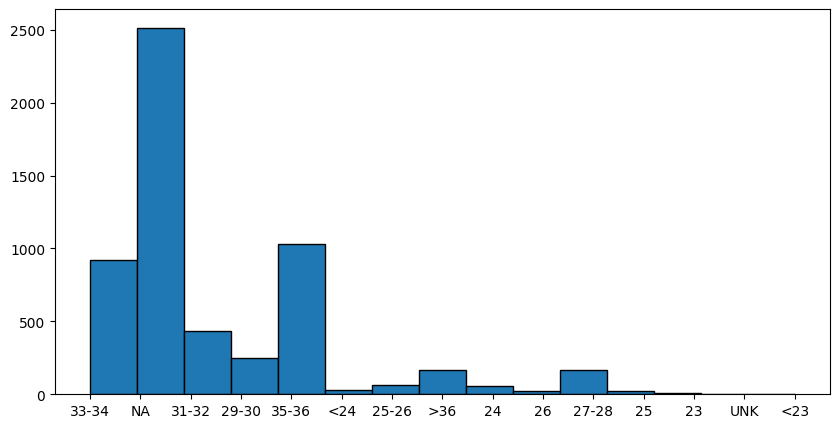

In [141]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.hist(final_cohort_ga_bw['ga'], edgecolor='black', bins=len(final_cohort_ga_bw['ga'].unique()))
plt.show()

In [42]:
dead_cohort = final_cohort[final_cohort['hospital_expire_flag'] == 1].copy()
dead_cohort['death_nicu_diff'] = pd.to_datetime(dead_cohort['deathtime']).astype(int)/(10**9)/60/60 - pd.to_datetime(dead_cohort['intime']).astype(int)/(10**9)/60/60
dead_cohort = dead_cohort[dead_cohort['death_nicu_diff'] >= 0]

In [38]:
dead_cohort = final_cohort[final_cohort['hospital_expire_flag'] == 1].copy()
dead_cohort['death_admit_diff'] = pd.to_datetime(dead_cohort['deathtime']).astype(int)/(10**9)/60/60 - pd.to_datetime(dead_cohort['admittime']).astype(int)/(10**9)/60/60
dead_cohort = dead_cohort[dead_cohort['death_admit_diff'] >= 0]

0
0.0


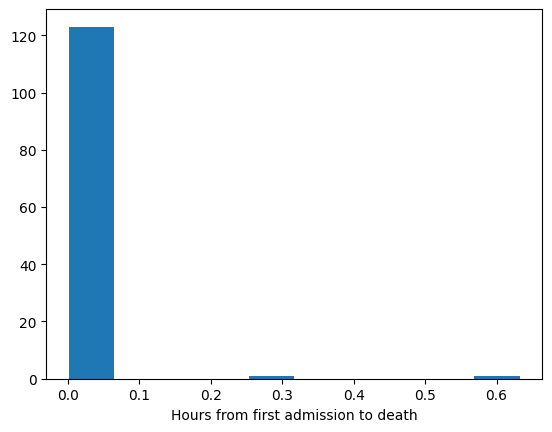

In [47]:
diff_key = 'nicu_admit_diff_days'
thresh = 2
print(len(dead_cohort[dead_cohort[diff_key] >= thresh]))
print(len(dead_cohort[dead_cohort[diff_key] >= thresh])/len(dead_cohort))
plt.hist(dead_cohort[dead_cohort[diff_key] < thresh][diff_key])
plt.xlabel("Hours from first admission to death")
plt.show()

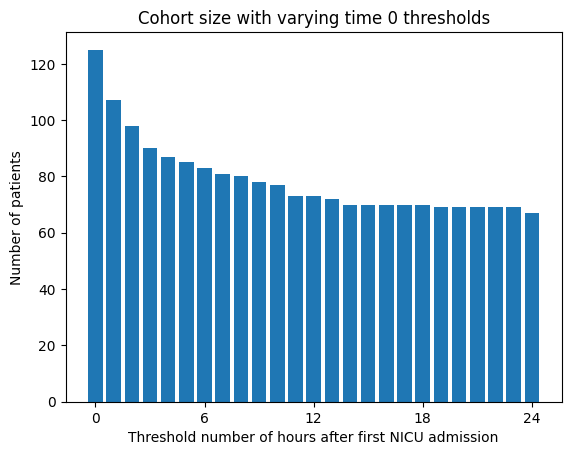

In [28]:
dead_cohort_flex = [len(dead_cohort[dead_cohort['death_nicu_diff'] >= t]) for t in range(25)]
plt.bar(range(25), dead_cohort_flex)
plt.xlabel("Threshold number of hours after first NICU admission")
plt.ylabel("Number of patients")
plt.title("Cohort size with varying time 0 thresholds")
plt.xticks(range(0,25,6))
plt.show()

In [ ]:
final_cohort_labs = final_cohort.merge(labs, 